# Final model - ensamble approch (LR and LSVM)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier
from sklearn.calibration import CalibratedClassifierCV # For SVM probabilities
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.pipeline import Pipeline
import re
import html
import joblib
import io # For handling file upload in Colab

# For Colab plotting inline
%matplotlib inline

In [1]:
from google.colab import files
uploaded = files.upload()

Saving spam.csv to spam.csv


In [4]:
# --- 1. Load and Clean Data) ---

# Initialize df and flag
initial_load_successful = False
df = pd.DataFrame()

# --- Adjust the filename if you uploaded it with a different name ---
filename = 'spam.csv' # Change this if your uploaded file has a different name

try:
    # Try standard load first
    df_temp = pd.read_csv(filename, encoding='latin-1')
    print("Data loaded with standard pd.read_csv.")
    # Check if it looks like the expected format (at least 2 columns)
    if len(df_temp.columns) >= 2:

        # Rename the first two columns to standard names
        cols = df_temp.columns.tolist()
        cols[0] = 'label'
        cols[1] = 'message'
        df_temp.columns = cols
        df = df_temp[['label', 'message']].copy() # Select only the first two
        initial_load_successful = True
    else:
        print("Standard load succeeded but resulted in < 2 columns.")
except Exception as e:
    print(f"Standard pd.read_csv failed or produced unexpected structure: {e}")

# If standard load didn't work or didn't give us 2 clean columns, use the fallback
if not initial_load_successful:
    print("Attempting fallback loading method...")
    try:
        # Load without assuming headers
        df_temp = pd.read_csv(filename, encoding='latin-1', header=None)
        print("Fallback: Data loaded with header=None.")

        # Check if we have at least two columns
        if df_temp.shape[1] >= 2:
             # Rename the first two columns explicitly
            df_temp.rename(columns={df_temp.columns[0]: 'label', df_temp.columns[1]: 'message'}, inplace=True)
            # Select only the label and message columns
            df = df_temp[['label', 'message']].copy()
            print("Fallback: Successfully extracted 'label' and 'message' columns.")
        else:
             raise ValueError("Fallback method failed: File has less than 2 columns.")

    except Exception as e_fallback:
        print(f"Fallback method also failed: {e_fallback}")
        # Raise a final error if neither method works
        raise ValueError("Could not correctly parse the CSV file into 'label' and 'message' columns using either method. Please check the file format.")

# Final check
if df.empty or 'label' not in df.columns or 'message' not in df.columns:
     raise ValueError("Critical Error: Could not create a DataFrame with 'label' and 'message' columns.")

# Data loaded successfully, proceed with inspection and cleaning
print("Data Shape:", df.shape)
print("Class Distribution:\n", df['label'].value_counts(normalize=True))

Data loaded with standard pd.read_csv.
Data Shape: (5572, 2)
Class Distribution:
 label
ham     0.865937
spam    0.134063
Name: proportion, dtype: float64


In [5]:
# --- 1a. Clean Text Data ---
# Simple cleaning function
def clean_text(text):
    if pd.isna(text):
        return ""
    text = html.unescape(text) # Handle HTML escape chars like &amp;
    text = text.lower()
    text = ' '.join(text.split())
    return text

df['cleaned_message'] = df['message'].apply(clean_text)
# Ensure labels are 'ham' and 'spam'
df = df[df['label'].isin(['ham', 'spam'])]
df['label_encoded'] = df['label'].map({'ham': 0, 'spam': 1})


# Check for any issues in encoding or mapping
print(f"\nMissing labels after encoding: {df['label_encoded'].isnull().sum()}")
if df['label_encoded'].isnull().sum() > 0:
    print("Warning: Some labels could not be encoded. Check for typos or extra categories.")
    # Drop rows with missing labels
    df = df.dropna(subset=['label_encoded'])


Missing labels after encoding: 0


In [8]:
# --- 2. Prepare Data ---
X = df['cleaned_message']
y = df['label_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTrain set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Train set size: 4457
Test set size: 1115


In [9]:
# --- 3a. Tuned Logistic Regression Pipeline ---
pipe_lr_best = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 3), stop_words='english', lowercase=True, use_idf=True)),
    ('classifier', LogisticRegression(C=10, class_weight='balanced', max_iter=1000, random_state=42))
])

# --- 3b. Tuned Linear SVM Pipeline (with Calibration for Soft Voting) ---
pipe_svm_base = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=8000, ngram_range=(1, 1), stop_words='english', lowercase=True)),
    ('classifier', LinearSVC(C=10, class_weight='balanced', random_state=42, max_iter=2000))
])
calibrated_svm = CalibratedClassifierCV(pipe_svm_base, cv=3, method='sigmoid')

In [10]:
# --- 4. Create the Hybrid Ensemble Model (Soft Voting) ---
ensemble_model = VotingClassifier(
    estimators=[
        ('lr_tuned', pipe_lr_best),
        ('svm_tuned_calibrated', calibrated_svm)
    ],
    voting='soft'
)

# --- 5. Train the Hybrid Model ---
print("\n--- Training Hybrid Ensemble Model (Soft Voting) ---")
ensemble_model.fit(X_train, y_train)


--- Training Hybrid Ensemble Model (Soft Voting) ---


VotingClassifier(estimators=[('lr_tuned',
                              Pipeline(steps=[('tfidf',
                                               TfidfVectorizer(max_features=5000,
                                                               ngram_range=(1,
                                                                            3),
                                                               stop_words='english')),
                                              ('classifier',
                                               LogisticRegression(C=10,
                                                                  class_weight='balanced',
                                                                  max_iter=1000,
                                                                  random_state=42))])),
                             ('svm_tuned_calibrated',
                              CalibratedClassifierCV(cv=3,
                                                     estimator=Pipeline(steps=[('tfidf',
                                                                                TfidfVectorizer(max_features=8000,
                                                                                                stop_words='english')),
                                                                               ('classifier',
                                                                                LinearSVC(C=10,
                                                                                          class_weight='balanced',
                                                                                          max_iter=2000,
                                                                                          random_state=42))])))],
                 voting='soft')


--- Evaluating Hybrid Ensemble Model (Test Set) ---
Accuracy: 0.9865
Precision: 0.9855
Recall: 0.9128
F1-Score: 0.9477
AUC-ROC: 0.9875

Classification Report:
              precision    recall  f1-score   support

         Ham       0.99      1.00      0.99       966
        Spam       0.99      0.91      0.95       149

    accuracy                           0.99      1115
   macro avg       0.99      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115



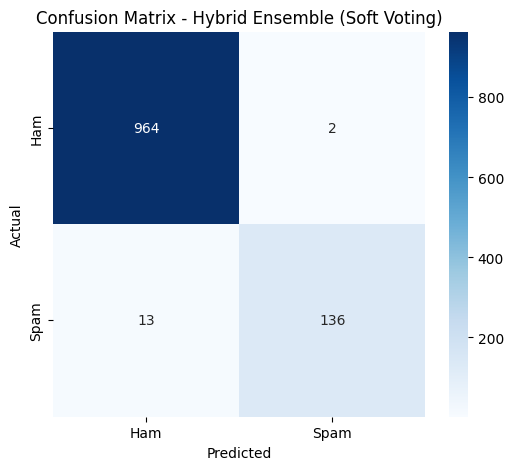

In [11]:
# --- 6. Evaluate the Hybrid Model on Test Set ---
print("\n--- Evaluating Hybrid Ensemble Model (Test Set) ---")
y_pred_ens = ensemble_model.predict(X_test)
y_pred_proba_ens = ensemble_model.predict_proba(X_test)[:, 1]

acc_ens = accuracy_score(y_test, y_pred_ens)
prec_ens = precision_score(y_test, y_pred_ens)
rec_ens = recall_score(y_test, y_pred_ens)
f1_ens = f1_score(y_test, y_pred_ens)
auc_ens = roc_auc_score(y_test, y_pred_proba_ens)

print(f"Accuracy: {acc_ens:.4f}")
print(f"Precision: {prec_ens:.4f}")
print(f"Recall: {rec_ens:.4f}")
print(f"F1-Score: {f1_ens:.4f}")
print(f"AUC-ROC: {auc_ens:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_ens, target_names=['Ham', 'Spam']))

# Confusion Matrix (Optional Visualization)
cm_ens = confusion_matrix(y_test, y_pred_ens)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_ens, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix - Hybrid Ensemble (Soft Voting)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
# --- 7. Save the Trained Model ---
model_filename = 'spam_hybrid_ensemble_model.pkl'

print(f"\n--- Saving the trained Hybrid Ensemble Model to '{model_filename}' ---")
try:
    joblib.dump(ensemble_model, model_filename)
    print("Model saved successfully!")
    # Optional: Download the file from Colab
    # from google.colab import files
    # files.download(model_filename)
except Exception as e:
    print(f"An error occurred while saving the model: {e}")

In [ ]:
# --- 8. (Optional) Demonstrate Loading and Using the Saved Model ---
# This part shows how to load the model later for predictions.
print(f"\n--- Demonstrating Loading and Using the Saved Model ---")
try:
    # Load the model
    loaded_model = joblib.load(model_filename)
    print("Model loaded successfully!")

    # Example prediction on new text (using data from the test set for demo)
    # In practice, `new_messages` would be a list of new, unseen text messages.
    sample_messages = X_test.head(3).tolist() # Get 3 examples from the test set
    print(f"\nMaking predictions on sample messages: {sample_messages}")

    # Predict using the loaded model
    predictions = loaded_model.predict(sample_messages)
    prediction_probabilities = loaded_model.predict_proba(sample_messages)

    # Display results
    for i, msg in enumerate(sample_messages):
        pred_label = "Spam" if predictions[i] == 1 else "Ham"
        prob_spam = prediction_probabilities[i][1]
        print(f"\nMessage: {msg}")
        print(f"Predicted Label: {pred_label}")
        print(f"Probability of Spam: {prob_spam:.4f}")

except FileNotFoundError:
    print(f"Model file '{model_filename}' not found. Please ensure the model was saved correctly.")
except Exception as e:
    print(f"An error occurred while loading or using the model: {e}")


--- Demonstrating Loading and Using the Saved Model ---
Model loaded successfully!

Making predictions on sample messages: ["oh right, ok. i'll make sure that i do loads of work during the day! got a really nasty cough today and is dry n shot so that should really help it!", 'i am in tirupur. call you da.', 'no that just means you have a fat head']

Message: oh right, ok. i'll make sure that i do loads of work during the day! got a really nasty cough today and is dry n shot so that should really help it!
Predicted Label: Ham
Probability of Spam: 0.0017

Message: i am in tirupur. call you da.
Predicted Label: Ham
Probability of Spam: 0.0041

Message: no that just means you have a fat head
Predicted Label: Ham
Probability of Spam: 0.0073


# Simple command line intraacction with model for testing

In [ ]:
# predict_sms.py
import joblib
import re
import html

# --- 1. Load the Trained Model ---
# Make sure 'spam_hybrid_ensemble_model.pkl' is in the same directory or provide the full path
model_filename = 'spam_hybrid_ensemble_model.pkl'
print(f"Loading model from {model_filename}...")
try:
    loaded_model = joblib.load(model_filename)
    print("Model loaded successfully!")
except FileNotFoundError:
    print(f"Error: Model file '{model_filename}' not found. Please ensure the model was saved correctly.")
    exit(1) # Exit if model not found
except Exception as e:
    print(f"Error loading model: {e}")
    exit(1)

# --- 2. Define the Preprocessing Function (Must Match Training) ---
def clean_text(text):
    """Cleans the text data - MUST MATCH the cleaning used during training."""
    if not isinstance(text, str): # Handle non-string inputs
        text = str(text)
    text = html.unescape(text) # Handle HTML escape chars like &amp;
    text = text.lower()
    text = ' '.join(text.split()) # Normalize whitespace
    # Add any other cleaning steps you used during training
    return text

# --- 3. Main Interaction Loop ---
print("\n--- SMS Spam Classifier ---")
print("Enter an SMS message to classify it as 'Spam' or 'Ham'.")
print("Type 'quit' or 'exit' to stop.\n")

while True:
    user_input = input("Enter SMS message: ")
    if user_input.lower() in ['quit', 'exit']:
        print("Exiting...")
        break

    if not user_input.strip(): # Check for empty input
        print("Please enter a message.")
        continue

    # --- 4. Preprocess the Input ---
    cleaned_input = [clean_text(user_input)] # Model expects a list of texts

    # --- 5. Make Prediction ---
    try:
        prediction = loaded_model.predict(cleaned_input)[0] # Get the first (and only) prediction
        # Get probability for the positive class (spam) if needed
        probability_spam = loaded_model.predict_proba(cleaned_input)[0][1]

        # --- 6. Display Result ---
        label = "Spam" if prediction == 1 else "Ham"
        print(f"Prediction: {label}")
        print(f"Confidence (Probability of Spam): {probability_spam:.4f}")
        print("-" * 20)

    except Exception as e:
        print(f"An error occurred during prediction: {e}")
        print("-" * 20)


Loading model from spam_hybrid_ensemble_model.pkl...
Model loaded successfully!

--- SMS Spam Classifier ---
Enter an SMS message to classify it as 'Spam' or 'Ham'.
Type 'quit' or 'exit' to stop.

Enter SMS message: hii itz me from india ,i have some work to deal with ,can u conatach me immediatly
Prediction: Ham
Confidence (Probability of Spam): 0.0140
--------------------
Enter SMS message: hii u get an offer upto 50% to win this prize click the link and signup
Prediction: Spam
Confidence (Probability of Spam): 0.9879
--------------------


KeyboardInterrupt: Interrupted by user